In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import yfinance as yf
import datetime

from valueinvesting import utils as utils

# 1. Load raw input
## Hardcoded block

In [2]:
evaluate_last_X_years = True
X=10
currency_pair = 'NOK=X'
numbers_in_currency = 'NOK'
share_name = 'NHY.OL'

# 1.2. Raw input statement data

In [3]:
route = f"../data/input/{share_name}_data.csv"
data = pd.read_csv(route, sep=';', parse_dates=['date'])
# replace -, extend missing 0-s, fix datatype
data = utils.replace_format_input(data)

In [4]:
owned_shares = pd.read_csv('../data/extras/owned_stocks.csv', sep=';', parse_dates=['date'])
owned_shares = owned_shares.loc[(owned_shares['stock'] == share_name) & (owned_shares['active'] == 'yes')]

## (OPTIONAL) Time Filtering - Last 7 years daat

In [5]:
if evaluate_last_X_years:
    data = data[data['date'] > datetime.datetime.today() - datetime.timedelta(days=X*366+93)]
    data = data.reset_index(drop=True)

data.head()

,date,revenue,cogs,gross_profit,net_profit,cash,acc_rec,inventory,curr_assets,goodwill,...,total_assets,acc_pay,short_term_debt,current_debt,curr_liab,long_term_debt,total_liab,cash_from_operating_activities,capex,shares
0,2013-12-31,16571,-11288,5283,-757,8412,0,10070,30681,0,...,116324,0,0,6220,18850,3986,46343,2789,-1043,2038
1,2014-03-31,18282,-12287,5995,462,6476,0,9599,30597,0,...,115724,0,0,6255,18330,3941,45191,-890,-585,2039
2,2014-06-30,18272,-12526,5746,269,6617,0,10213,29799,0,...,116647,0,0,6141,17684,4093,46106,1179,-705,2039
3,2014-09-30,19698,-12970,6728,666,6045,0,10334,29750,0,...,114275,0,0,5007,16500,4850,45159,1151,-871,2039
4,2014-12-31,21656,-13697,7959,-166,9253,0,12642,35927,0,...,126273,0,0,6039,19116,5128,52243,4386,-1133,2039


## Calculate date when quaterly reports could be available

In [6]:
data = utils.calculate_real_date(data)

# 2. Filter out unnecesary columns

In [7]:
data = utils.filter_raw_data(data)
data.tail()

,date,real_date,shares,revenue,cogs,gross_profit,net_profit,cash,acc_rec,inventory,...,intangible_assets,total_assets,acc_pay,short_term_debt,current_debt,curr_liab,long_term_debt,total_liab,cash_from_operating_activities,capex
36,2022-12-31,2023-02-11,2051,44075,-28857,15218,157,29805,0,30035,...,9280,198618,0,0,6746,42807,26029,96163,8409,-3690
37,2023-03-31,2023-04-21,2029,48534,-31295,17239,1144,30873,0,30216,...,9839,211395,0,0,5899,42342,29615,102813,3704,-2633
38,2023-06-30,2023-07-21,2029,53630,-32109,21521,5056,22453,0,28808,...,10215,208506,0,0,5271,40393,29756,101633,10110,-3476
39,2023-09-30,2023-10-21,2029,44702,-30501,14201,-625,19105,0,27648,...,10823,205260,0,0,5764,41718,29944,102197,5088,-3200
40,2023-12-31,2024-02-11,2029,46754,-29633,17121,-2772,24618,0,25449,...,8447,206462,0,0,7111,43892,28978,105884,3130,-4329


## Pull historical average USD national currency rates and add to the dataframe

In [8]:
data['usd_nat_currency'] = utils.daily_price(
    ticker=currency_pair,
    end=data['date'],
    days_earlier=90
    )

# drop rows, when USD rates wasn't available
data = data[data['usd_nat_currency'].notna()]

data.tail()

,date,real_date,shares,revenue,cogs,gross_profit,net_profit,cash,acc_rec,inventory,...,total_assets,acc_pay,short_term_debt,current_debt,curr_liab,long_term_debt,total_liab,cash_from_operating_activities,capex,usd_nat_currency
36,2022-12-31,2023-02-11,2051,44075,-28857,15218,157,29805,0,30035,...,198618,0,0,6746,42807,26029,96163,8409,-3690,10.186402
37,2023-03-31,2023-04-21,2029,48534,-31295,17239,1144,30873,0,30216,...,211395,0,0,5899,42342,29615,102813,3704,-2633,10.221379
38,2023-06-30,2023-07-21,2029,53630,-32109,21521,5056,22453,0,28808,...,208506,0,0,5271,40393,29756,101633,10110,-3476,10.699984
39,2023-09-30,2023-10-21,2029,44702,-30501,14201,-625,19105,0,27648,...,205260,0,0,5764,41718,29944,102197,5088,-3200,10.483742
40,2023-12-31,2024-02-11,2029,46754,-29633,17121,-2772,24618,0,25449,...,206462,0,0,7111,43892,28978,105884,3130,-4329,10.821103


## Convert USD values related to IS, BS, CFS to national currency

In [9]:
# convert columns into national currency if necessary
if numbers_in_currency == 'USD':
    data_nat_curr = utils.convert_national_currency(input_data=data, currency=data)
else:
    data_nat_curr = data.copy()
data_nat_curr.tail()

,date,real_date,shares,revenue,cogs,gross_profit,net_profit,cash,acc_rec,inventory,...,total_assets,acc_pay,short_term_debt,current_debt,curr_liab,long_term_debt,total_liab,cash_from_operating_activities,capex,usd_nat_currency
36,2022-12-31,2023-02-11,2051,44075,-28857,15218,157,29805,0,30035,...,198618,0,0,6746,42807,26029,96163,8409,-3690,10.186402
37,2023-03-31,2023-04-21,2029,48534,-31295,17239,1144,30873,0,30216,...,211395,0,0,5899,42342,29615,102813,3704,-2633,10.221379
38,2023-06-30,2023-07-21,2029,53630,-32109,21521,5056,22453,0,28808,...,208506,0,0,5271,40393,29756,101633,10110,-3476,10.699984
39,2023-09-30,2023-10-21,2029,44702,-30501,14201,-625,19105,0,27648,...,205260,0,0,5764,41718,29944,102197,5088,-3200,10.483742
40,2023-12-31,2024-02-11,2029,46754,-29633,17121,-2772,24618,0,25449,...,206462,0,0,7111,43892,28978,105884,3130,-4329,10.821103


# 3. Calculate input to Value Raios (eps, bv per share, fcf)
## filter out unwanted columns

In [10]:
filtered_nat_curr = utils.calculate_input_value_ratios(data_nat_curr)

## Calculate input values to value ratios

In [11]:
ratios_nat_curr = utils.ratios_input_filter(filtered_nat_curr)

In [12]:
ratios_nat_curr = utils.evaluate_performance(input=filtered_nat_curr, output=ratios_nat_curr)

# 4. Pull historical share prices and merge with sattement data

In [13]:
# pull weekly share prices and merge with the value ratios
merged_nat_curr = utils.add_share_prices_to_value_ratios(share_name, data, ratios_nat_curr)
merged_nat_curr.head()

,real_date,share_price,date,revenue,eps,bv_per_share,shares,fcf,fcf_per_share,cash,...,equity_ratio,debt_ratio,acc_rec_ratio,acc_pay_ratio,cash_turnover,inventory_turnover,gross_profit_margin,net_profit_margin,roa,roe
0,2014-02-17,20.539011,2013-12-31,16571.0,-1.48577,34.338077,2038.0,15328.0,7.521099,8412.0,...,0.601604,0.398396,inf,inf,7.879696,4.483813,0.31881,-0.045682,-0.026031,-0.043269
1,2014-02-24,20.299789,2013-12-31,16571.0,-1.48577,34.338077,2038.0,15328.0,7.521099,8412.0,...,0.601604,0.398396,inf,inf,7.879696,4.483813,0.31881,-0.045682,-0.026031,-0.043269
2,2014-03-03,20.368139,2013-12-31,16571.0,-1.48577,34.338077,2038.0,15328.0,7.521099,8412.0,...,0.601604,0.398396,inf,inf,7.879696,4.483813,0.31881,-0.045682,-0.026031,-0.043269
3,2014-03-10,19.520609,2013-12-31,16571.0,-1.48577,34.338077,2038.0,15328.0,7.521099,8412.0,...,0.601604,0.398396,inf,inf,7.879696,4.483813,0.31881,-0.045682,-0.026031,-0.043269
4,2014-03-17,19.828178,2013-12-31,16571.0,-1.48577,34.338077,2038.0,15328.0,7.521099,8412.0,...,0.601604,0.398396,inf,inf,7.879696,4.483813,0.31881,-0.045682,-0.026031,-0.043269


# Calculate price ratios (P/E, P/B, P/S, P/FCF)

In [14]:
merged_nat_curr = utils.price_ratios(merged_nat_curr)
merged_nat_curr.head()

,real_date,share_price,date,revenue,eps,bv_per_share,shares,fcf,fcf_per_share,cash,...,inventory_turnover,gross_profit_margin,net_profit_margin,roa,roe,pe_ratio,pb_ratio,ps_ratio,ev_revenue,pfcf_ratio
0,2014-02-17,20.539011,2013-12-31,16571.0,-1.48577,34.338077,2038.0,15328.0,7.521099,8412.0,...,4.483813,0.31881,-0.045682,-0.026031,-0.043269,-13.823813,0.598141,0.631502,1.203752,2.730852
1,2014-02-24,20.299789,2013-12-31,16571.0,-1.48577,34.338077,2038.0,15328.0,7.521099,8412.0,...,4.483813,0.31881,-0.045682,-0.026031,-0.043269,-13.662804,0.591174,0.624147,1.196397,2.699046
2,2014-03-03,20.368139,2013-12-31,16571.0,-1.48577,34.338077,2038.0,15328.0,7.521099,8412.0,...,4.483813,0.31881,-0.045682,-0.026031,-0.043269,-13.708807,0.593165,0.626249,1.198498,2.708133
3,2014-03-10,19.520609,2013-12-31,16571.0,-1.48577,34.338077,2038.0,15328.0,7.521099,8412.0,...,4.483813,0.31881,-0.045682,-0.026031,-0.043269,-13.138375,0.568483,0.600190,1.172440,2.595446
4,2014-03-17,19.828178,2013-12-31,16571.0,-1.48577,34.338077,2038.0,15328.0,7.521099,8412.0,...,4.483813,0.31881,-0.045682,-0.026031,-0.043269,-13.345386,0.577440,0.609647,1.181896,2.636341


# Calculate Dividend yield and currency-share price correlation

In [15]:
# get daily historical USD-national currency rates
usd_nat_curr = utils.get_historical_currency_rate(currency_pair, merged_nat_curr)

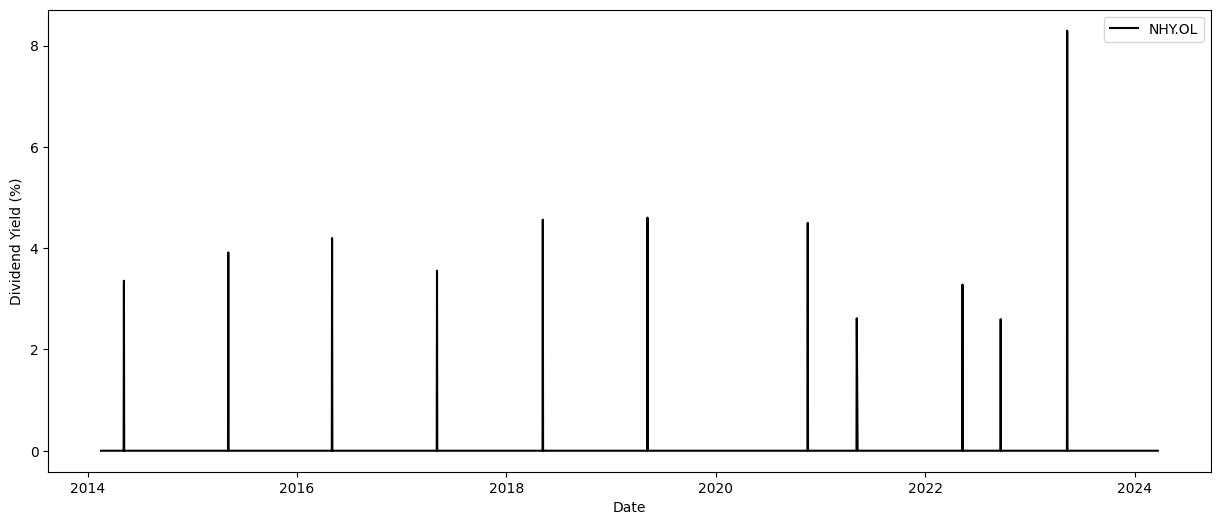

In [16]:
# get share prices and dividend yield data
ticker_all_price = utils.get_historical_share_dividend(share_name, merged_nat_curr)

currency_rate    0.564106
share_price      1.000000
Name: share_price, dtype: float64


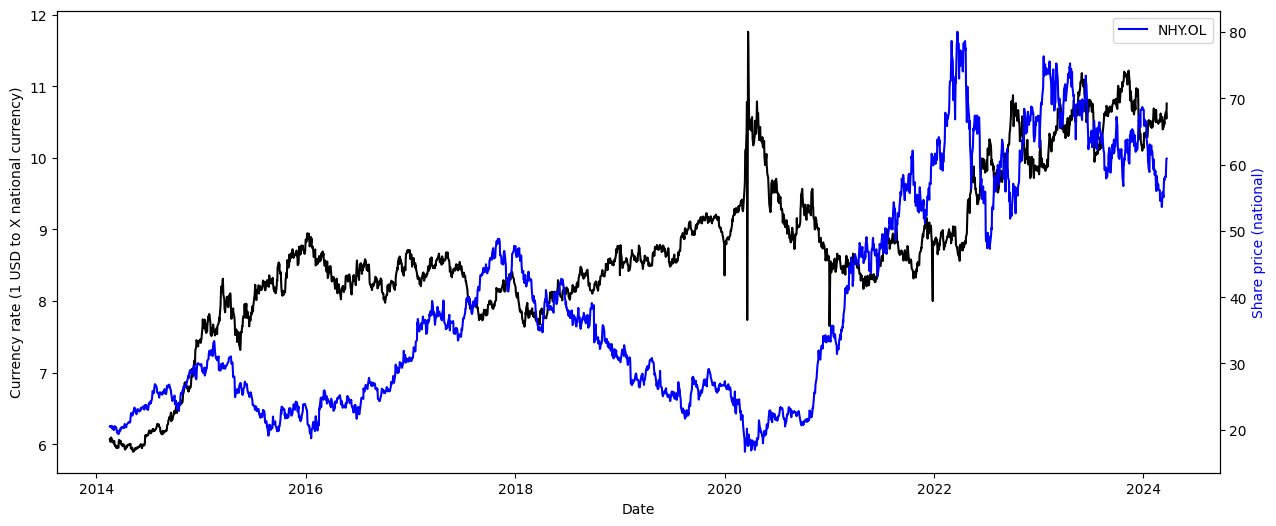

In [17]:
# Pearson's correlation coefficient between share price and USD - national currency rate
utils.get_currency_share_price_correlation(share_name, usd_nat_curr, ticker_all_price)

# Share price and value ratios

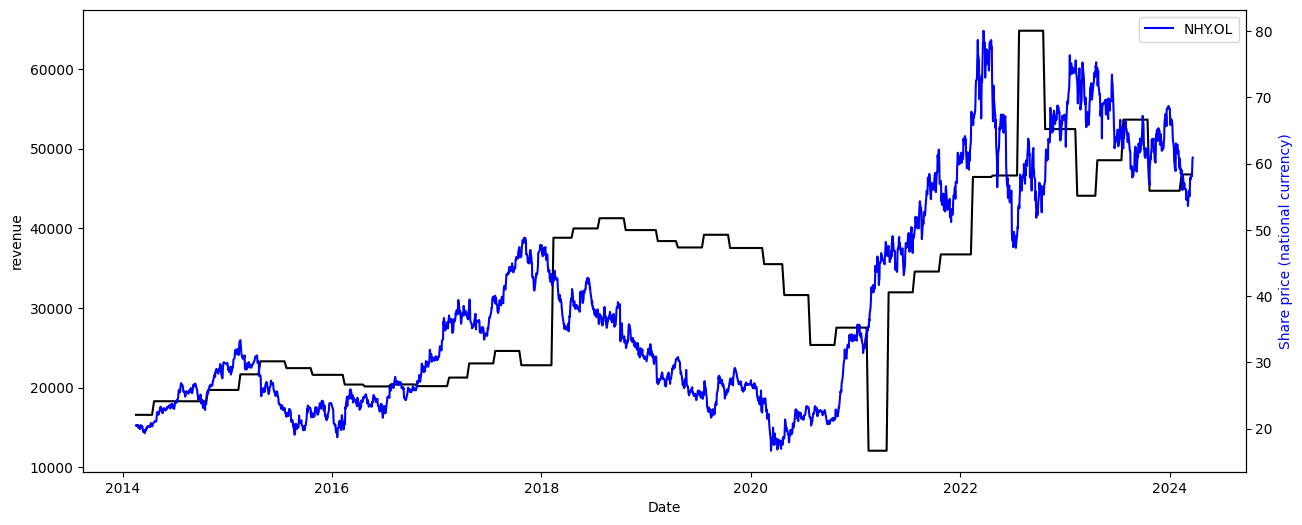

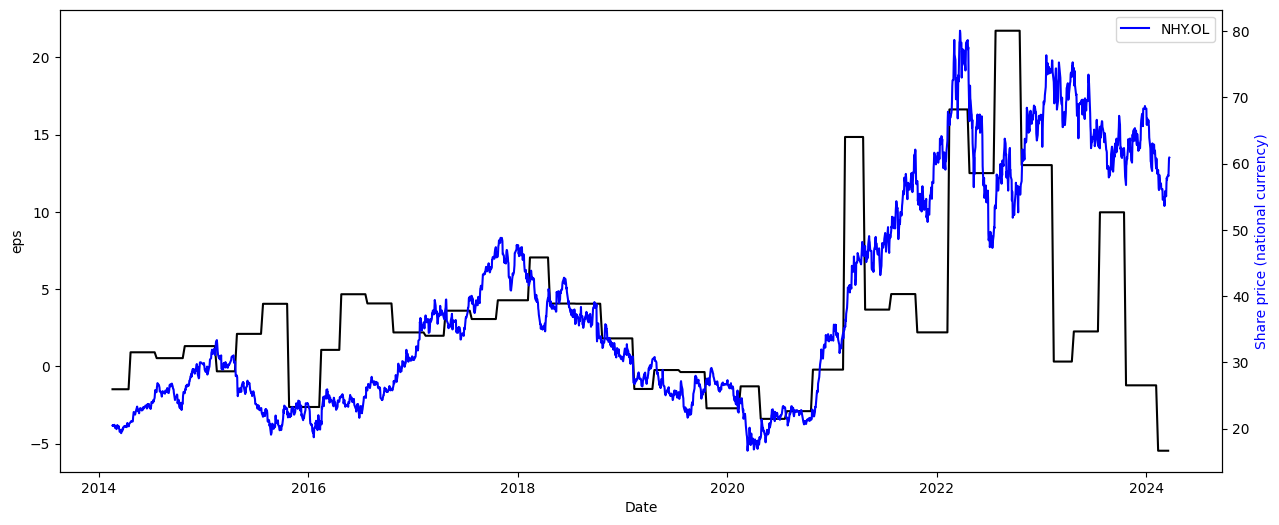

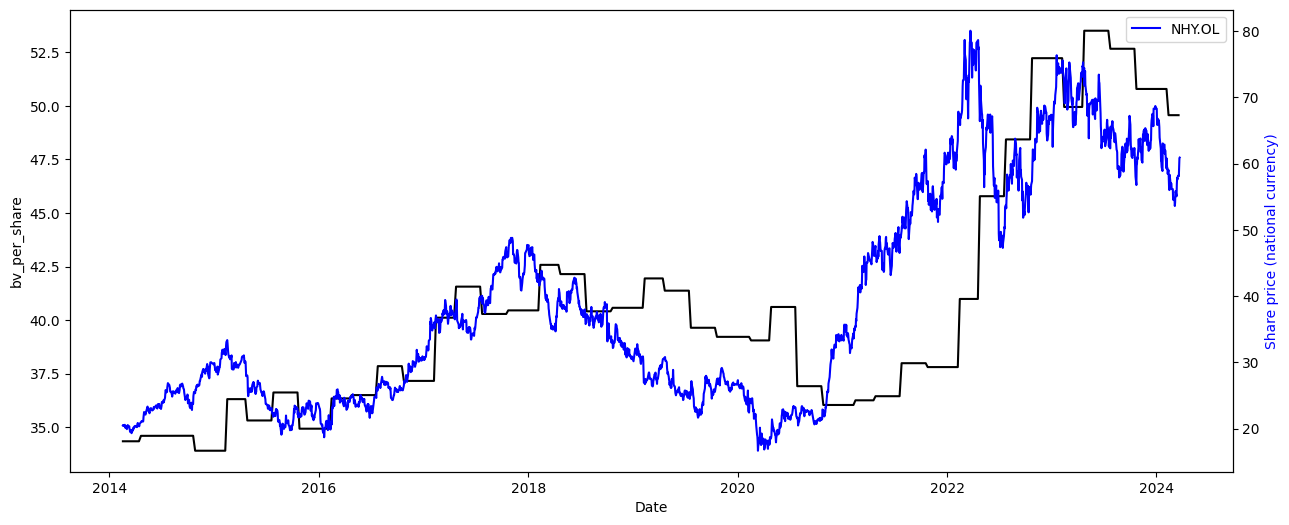

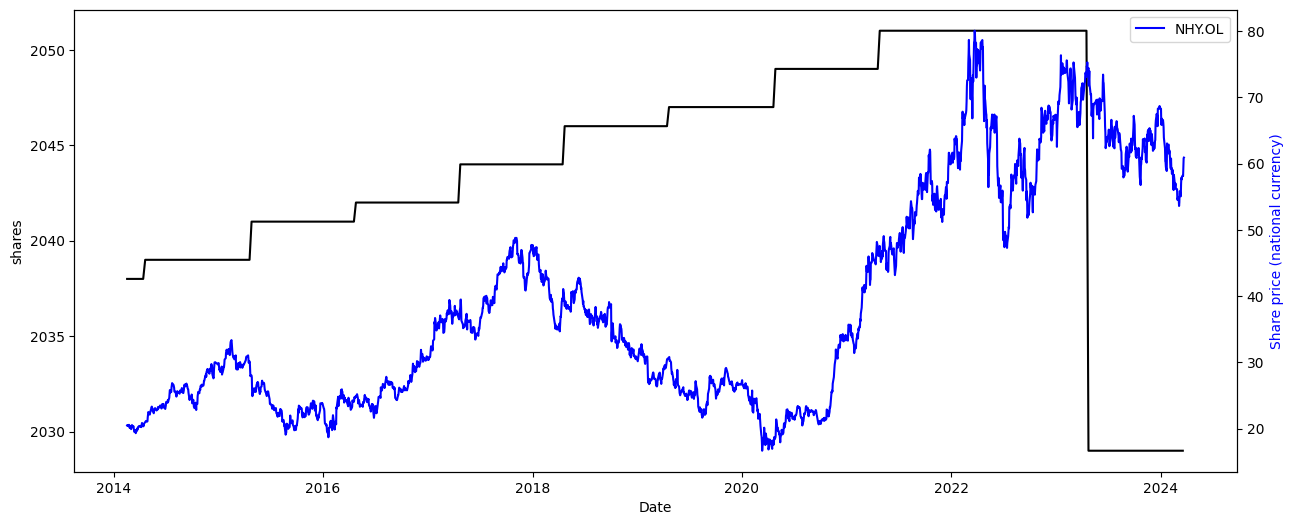

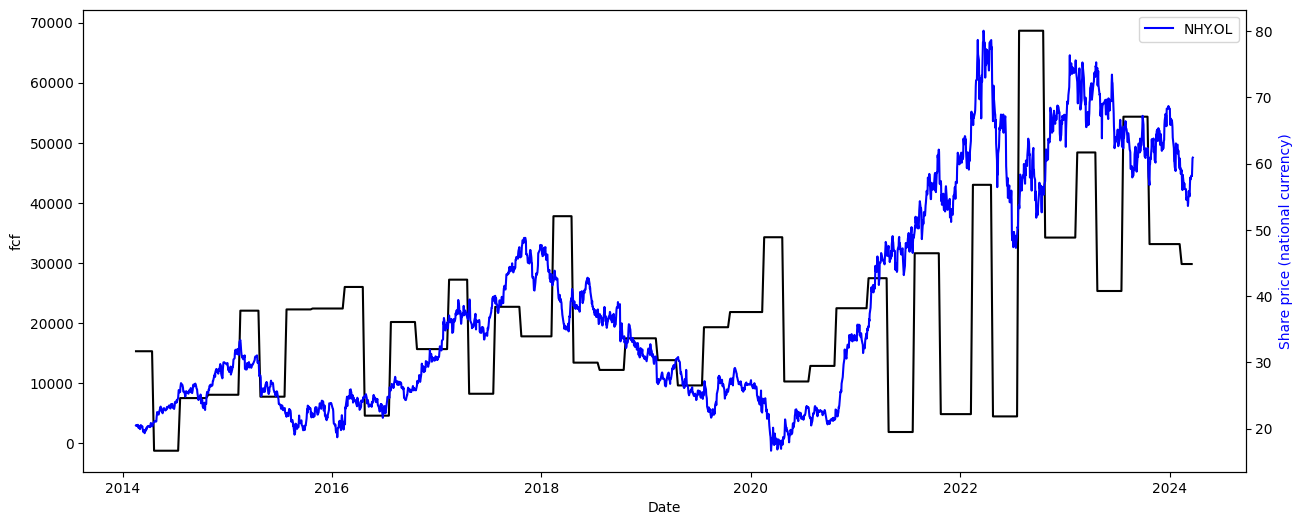

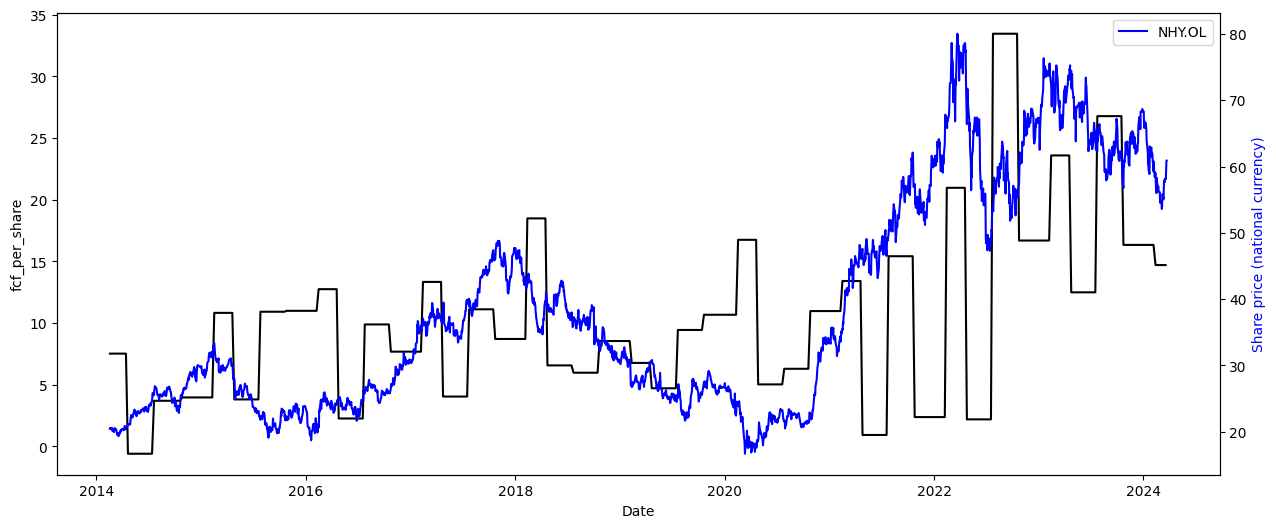

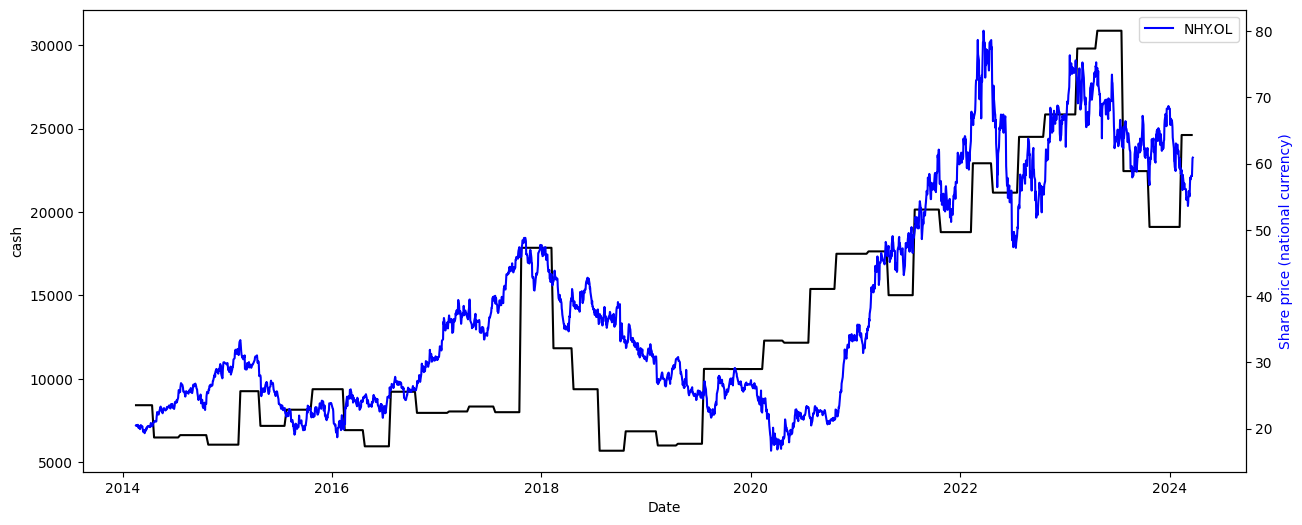

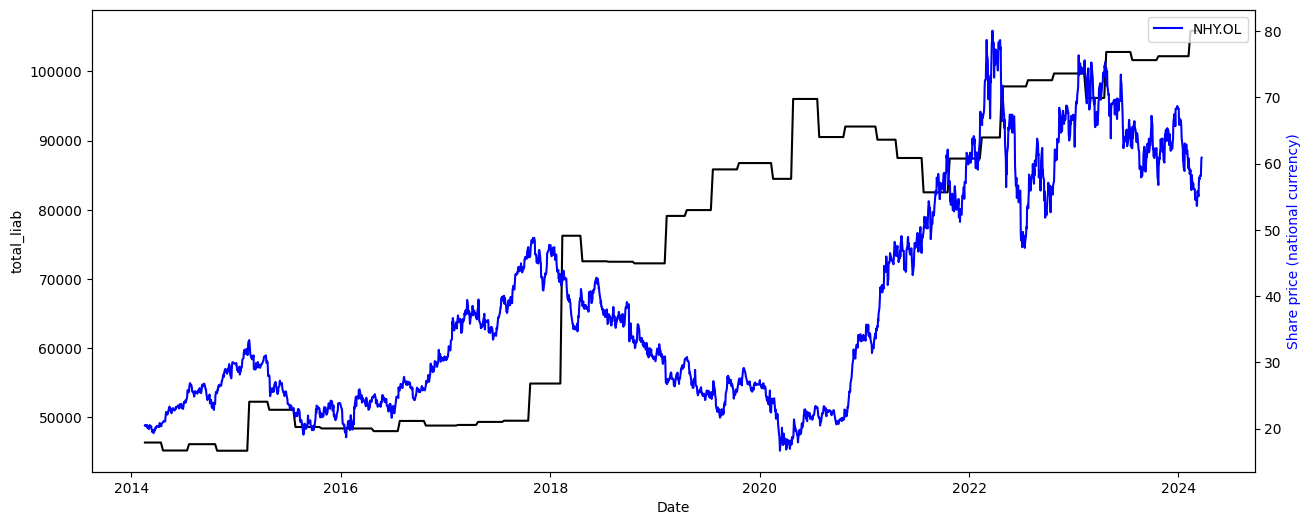

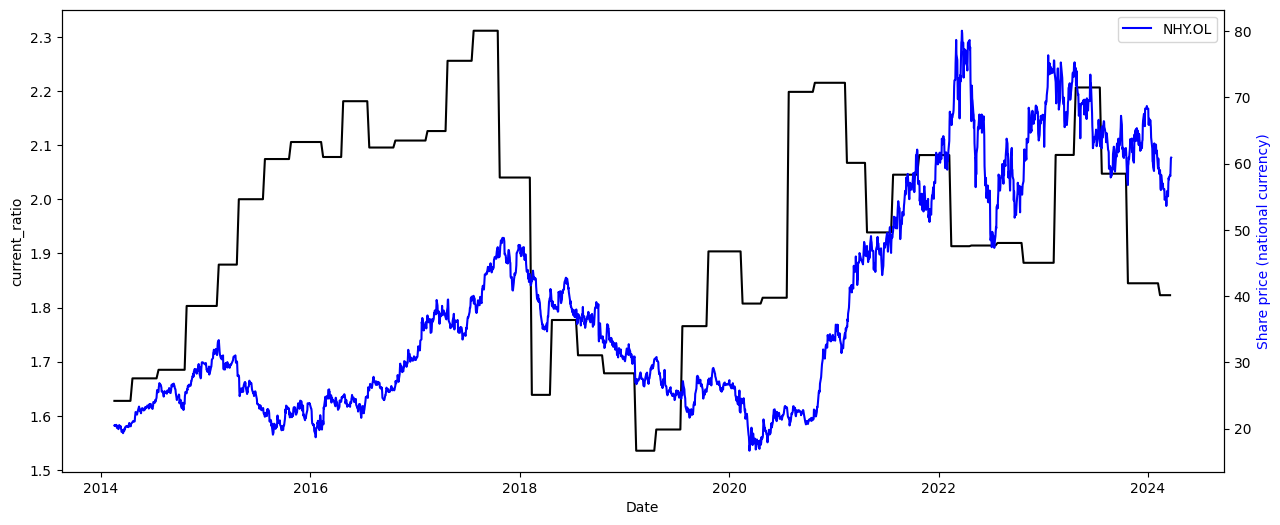

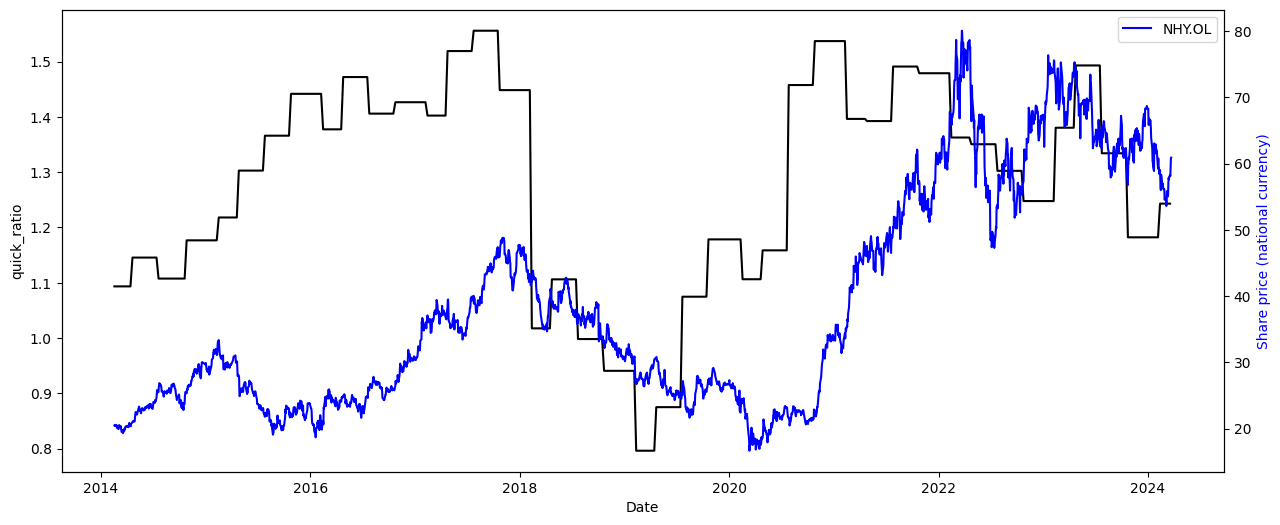

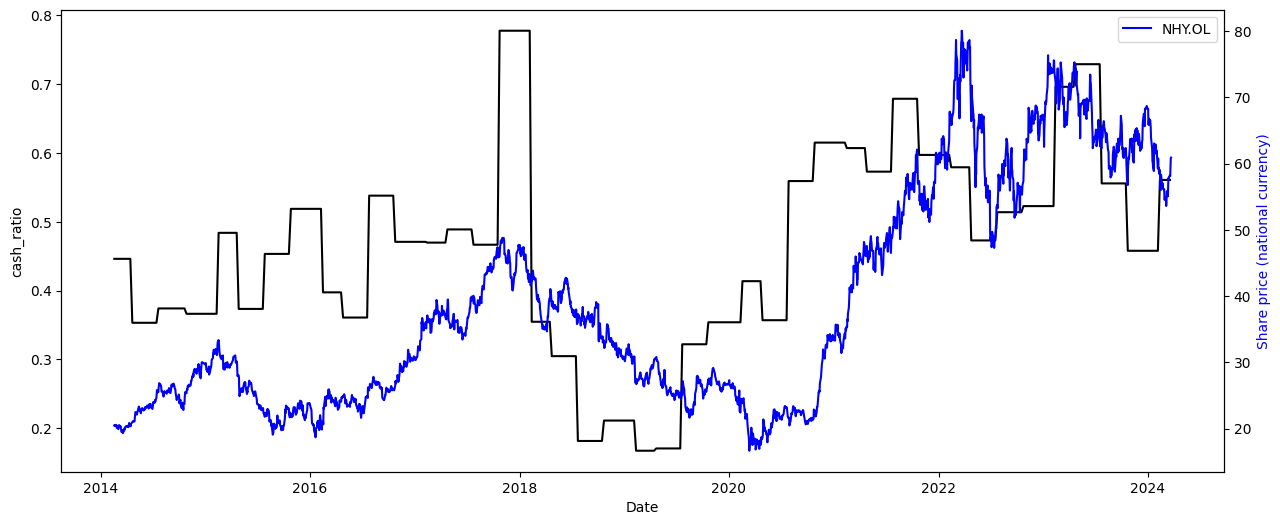

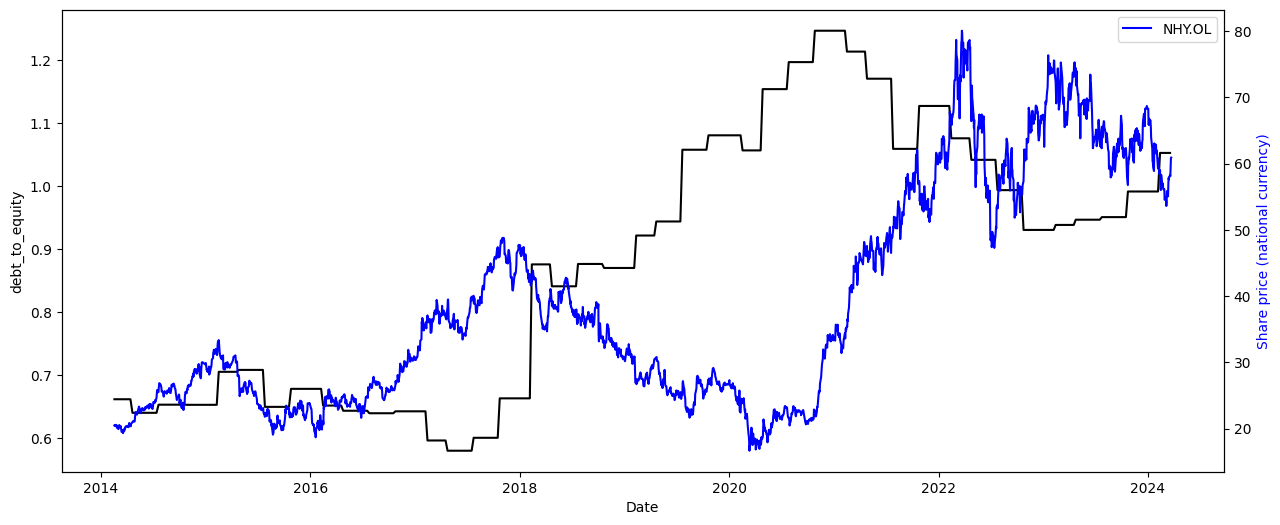

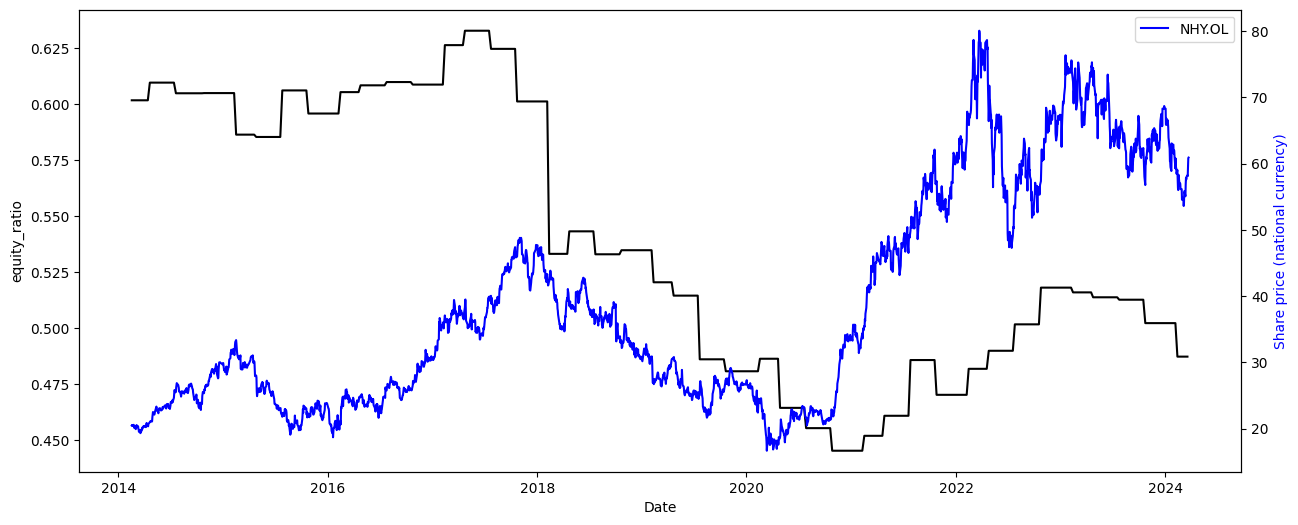

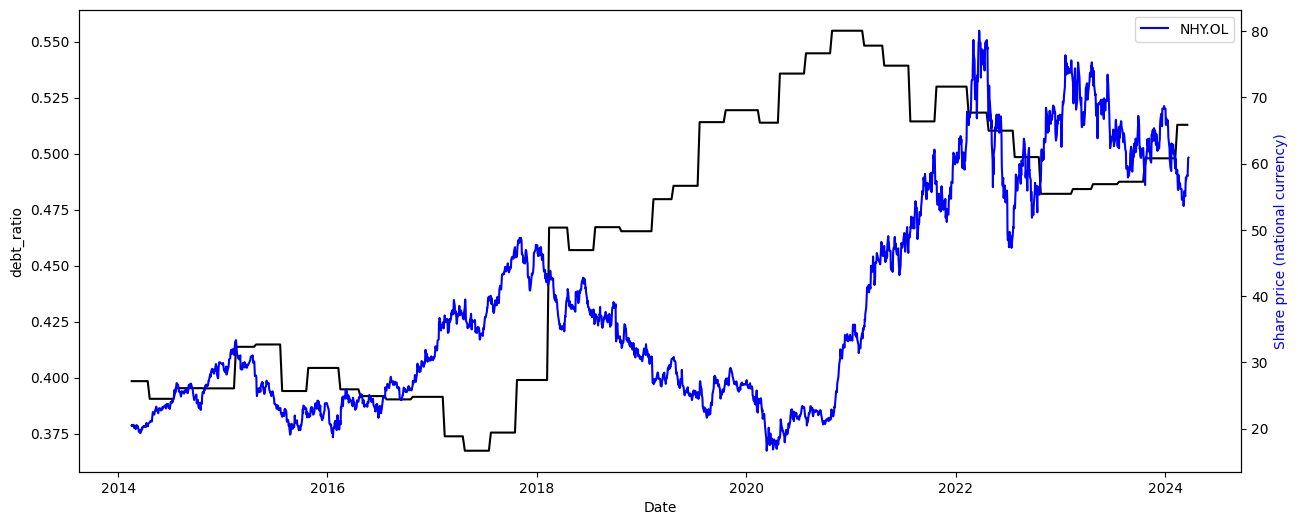

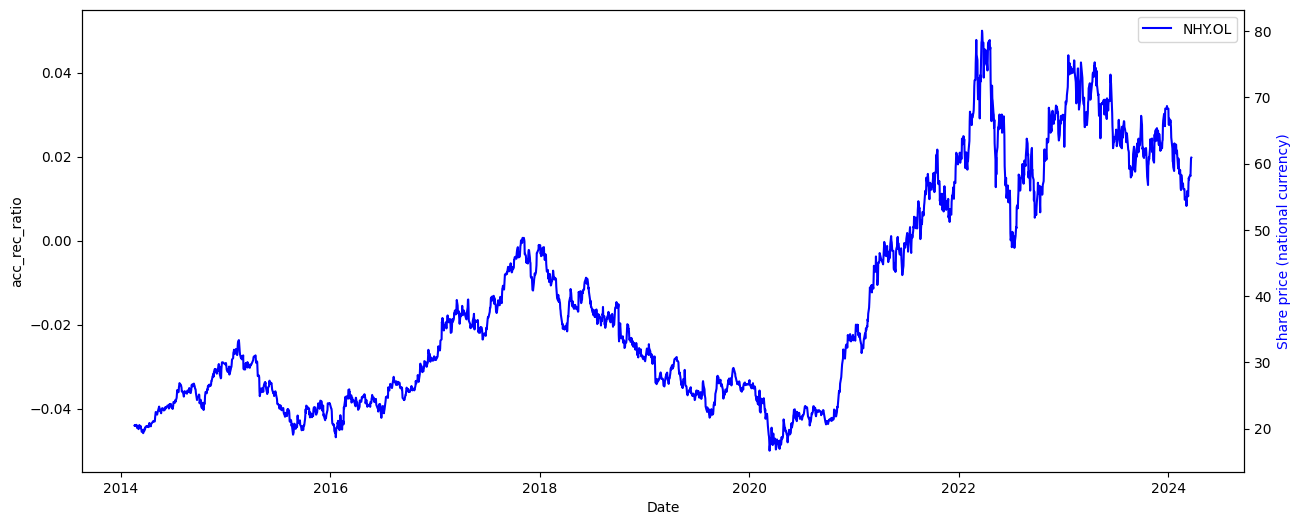

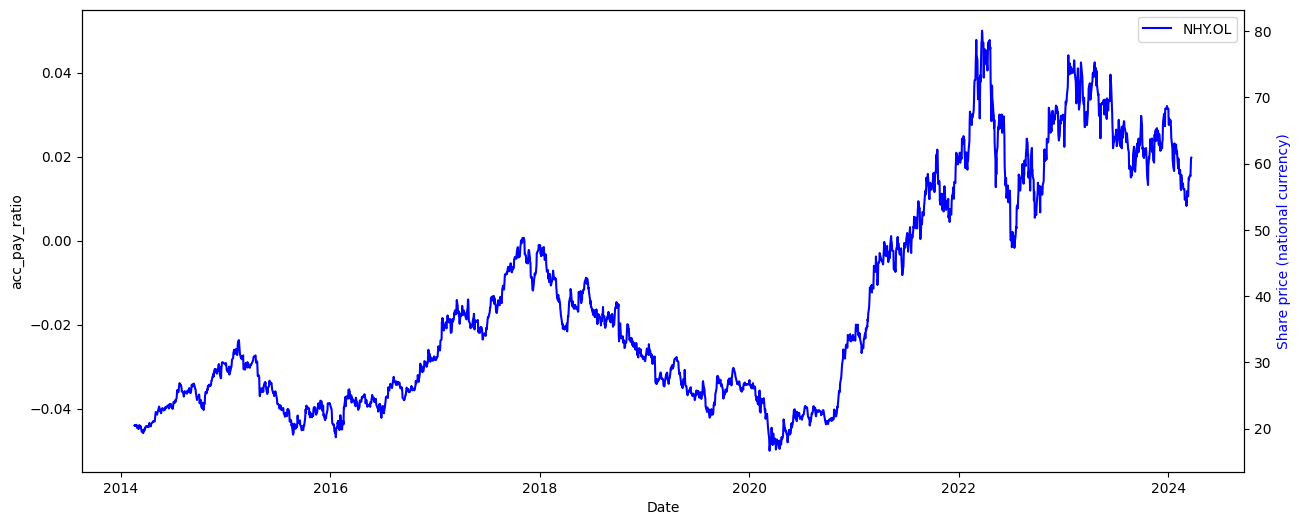

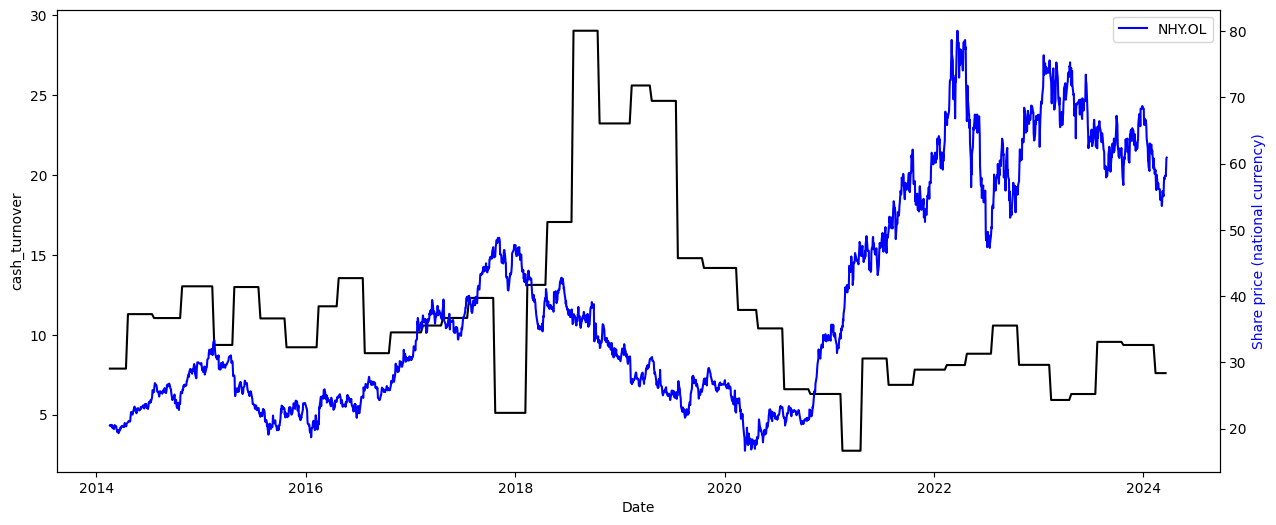

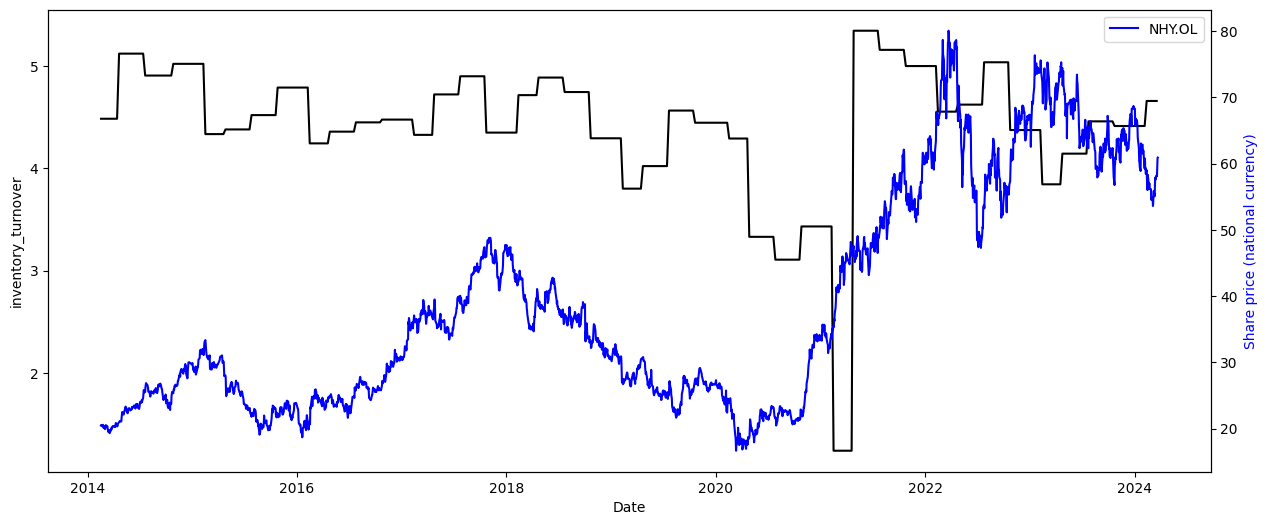

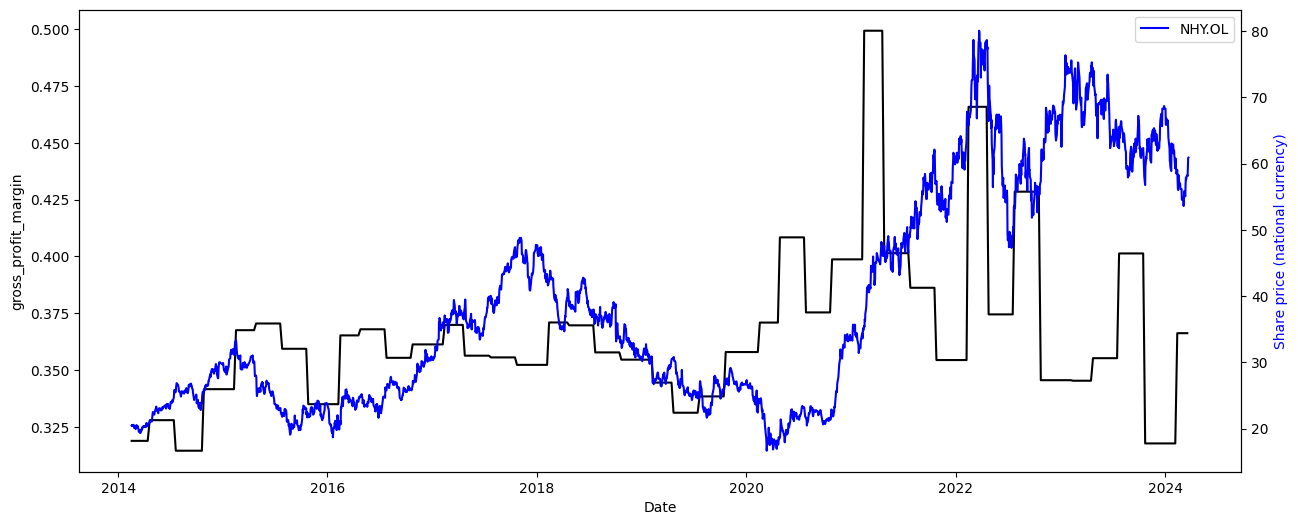

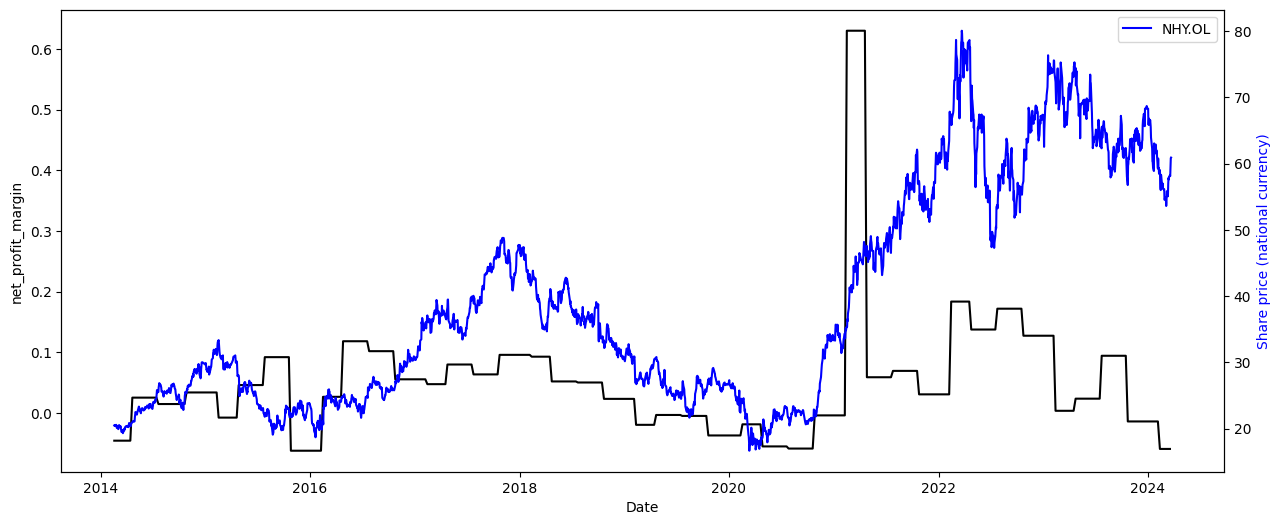

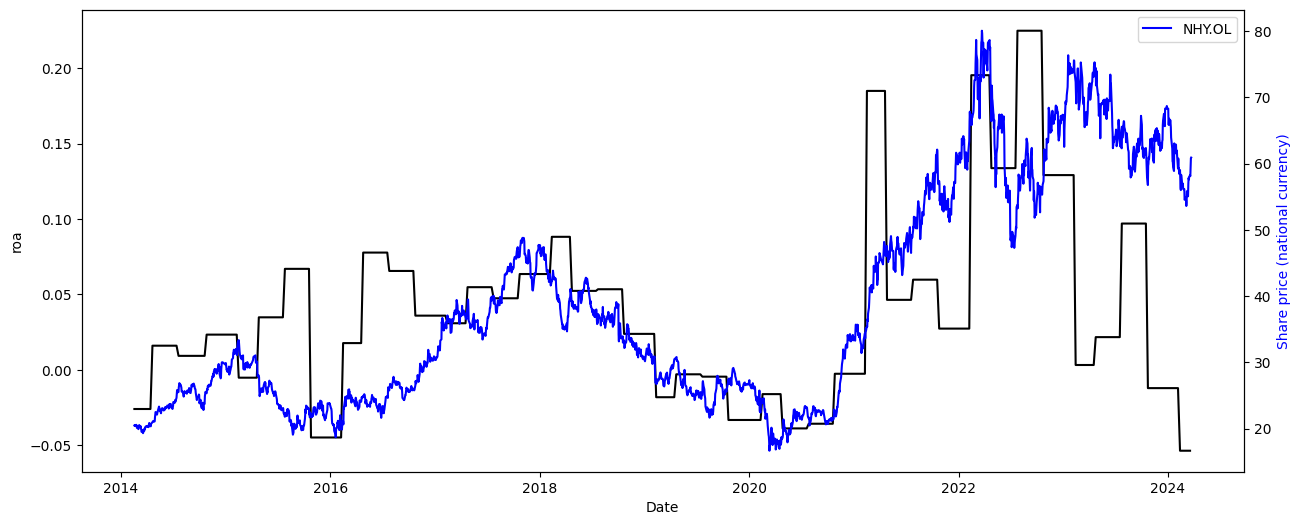

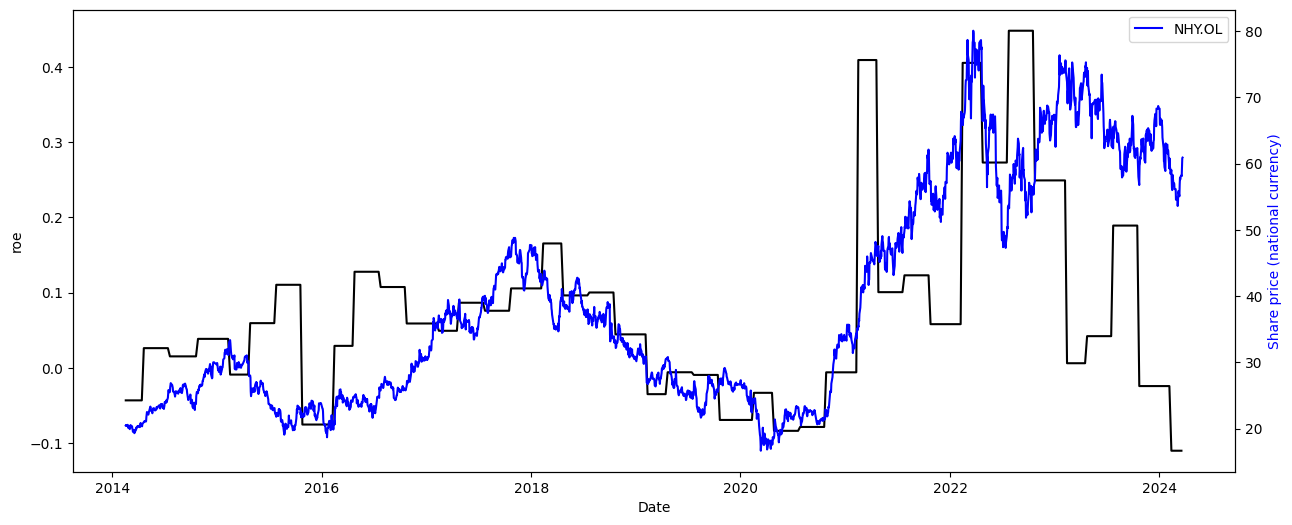

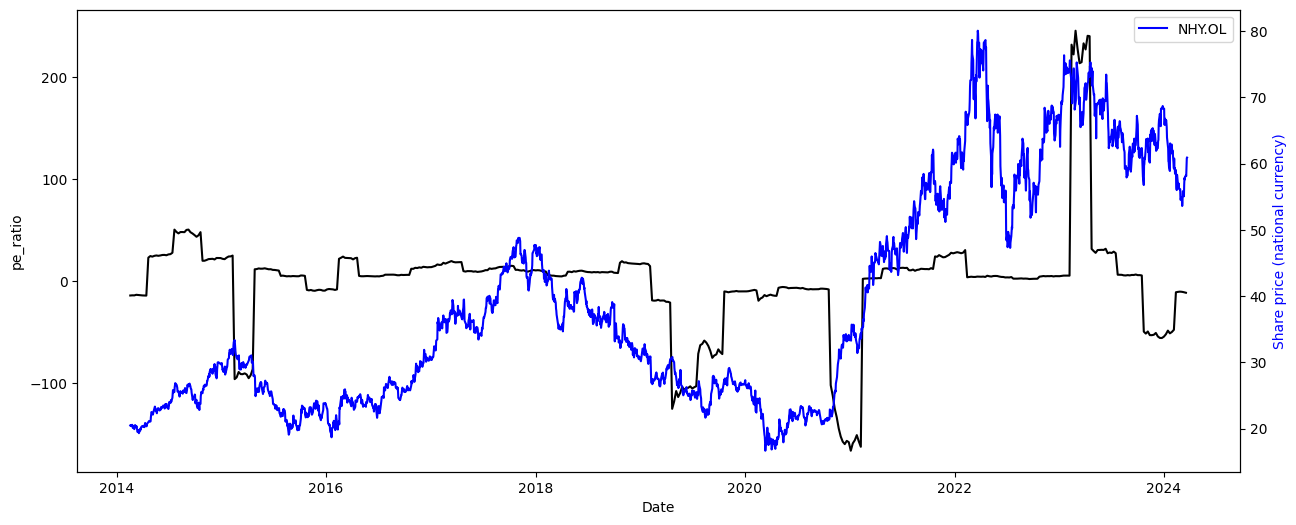

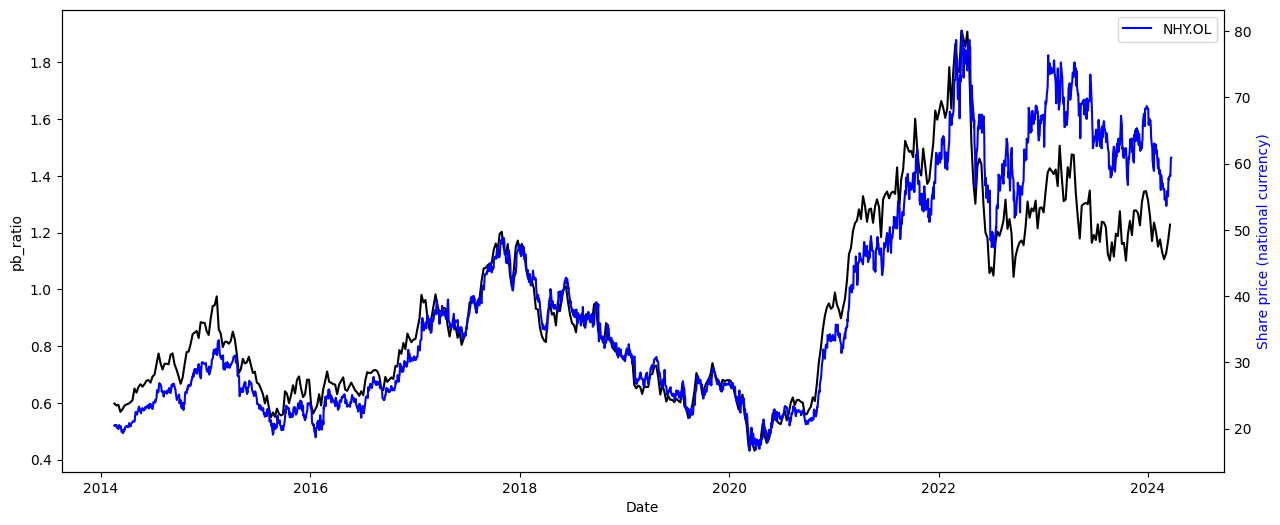

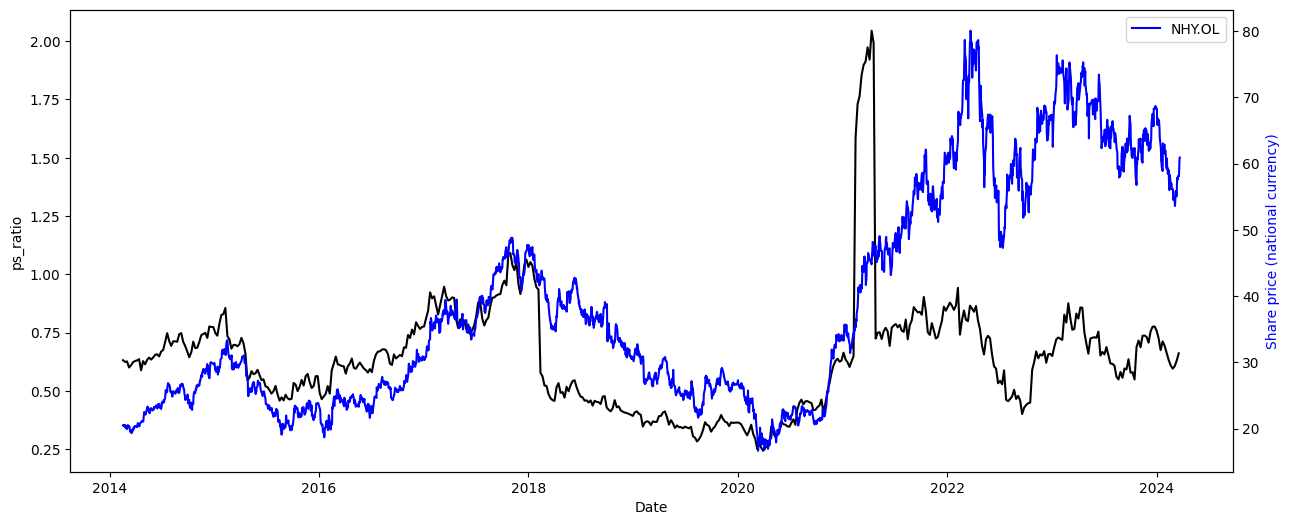

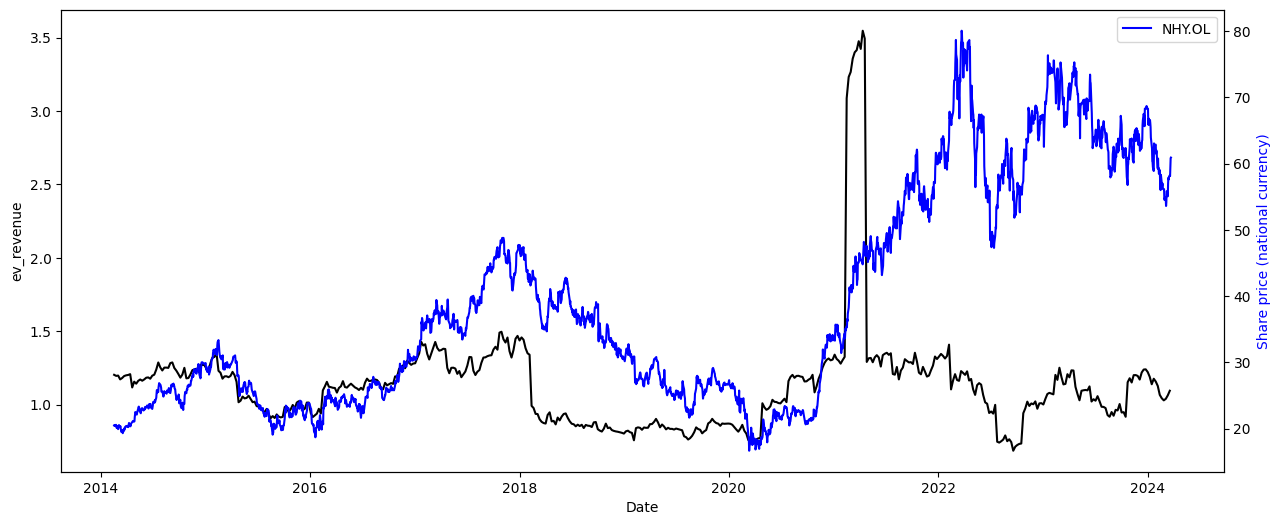

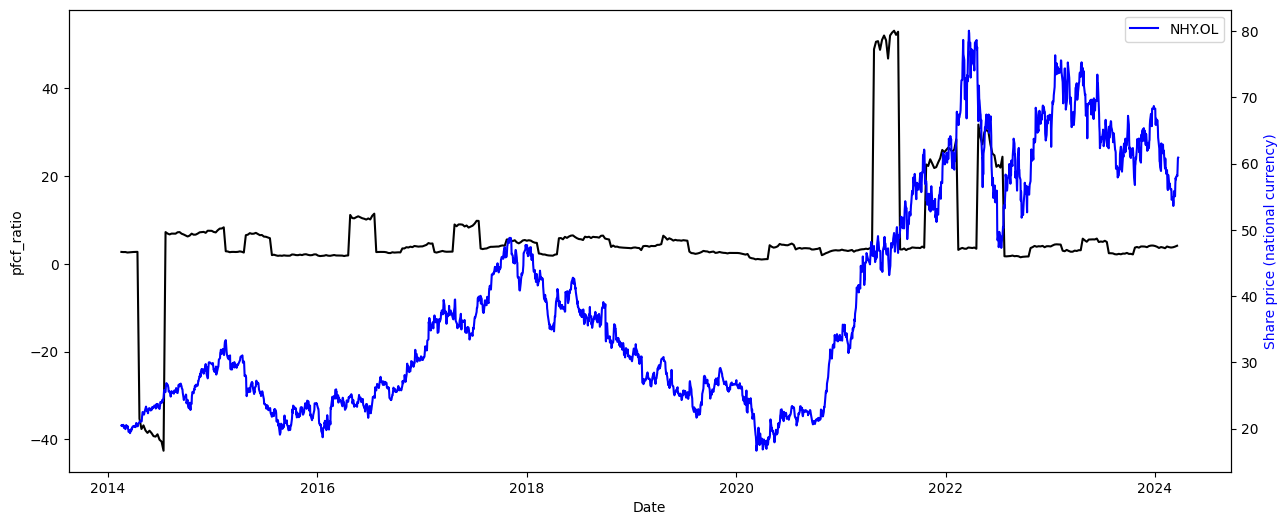

In [18]:
for column in merged_nat_curr.columns[3:]:
    fig, ax1 = plt.subplots(figsize=(15, 6))

    ax2 = ax1.twinx()
    ax1.plot(merged_nat_curr['real_date'], merged_nat_curr[column], color='k', label=merged_nat_curr)
    ax2.plot(ticker_all_price.index, ticker_all_price['Close'], color='b', label=share_name)

    ax1.set_xlabel('Date')
    ax1.set_ylabel(column, color='k')
    ax2.set_ylabel('Share price (national currency)', color='b')

    plt.legend()
    plt.show()

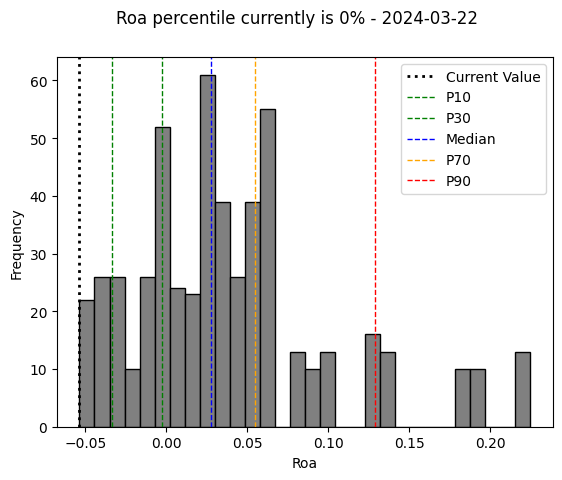

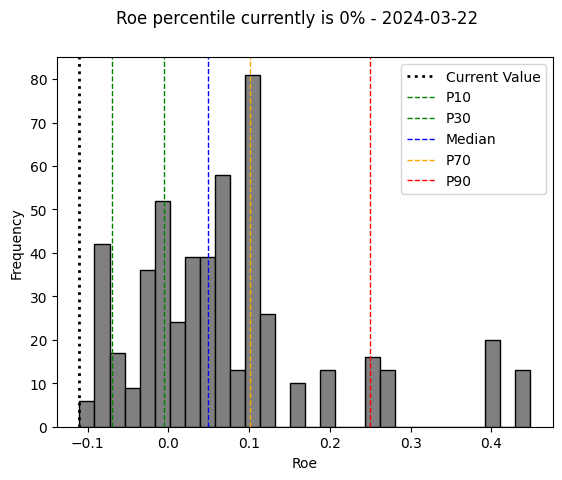

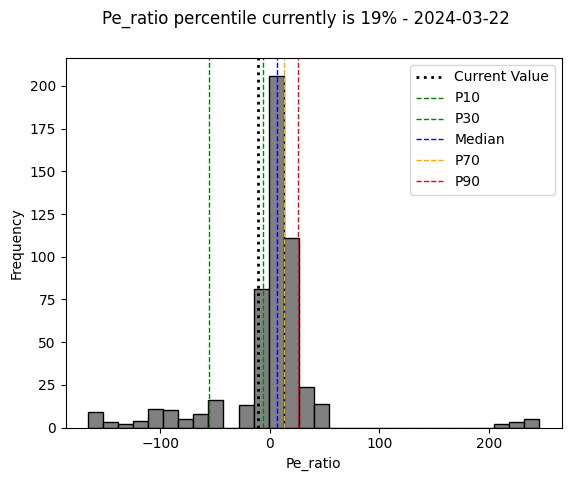

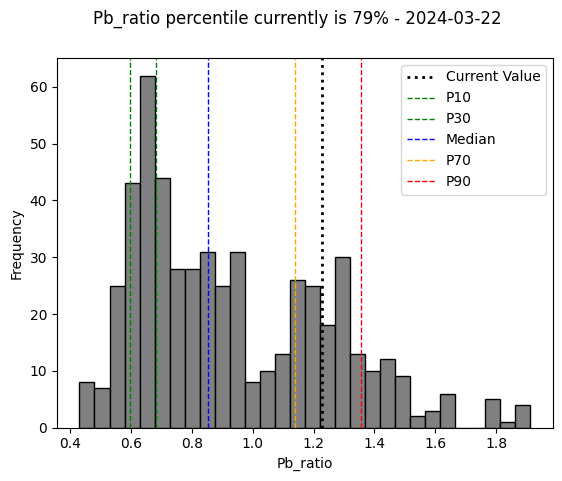

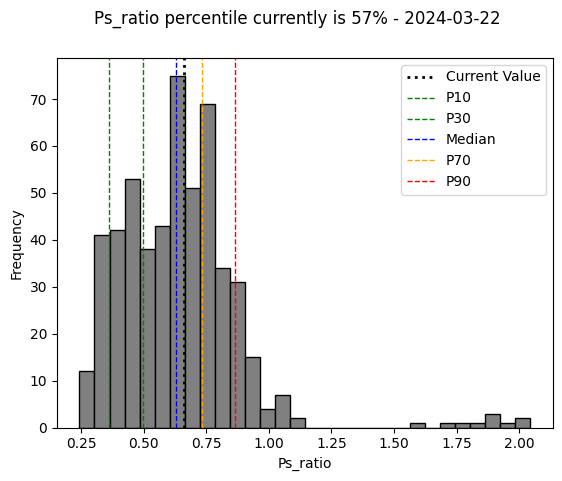

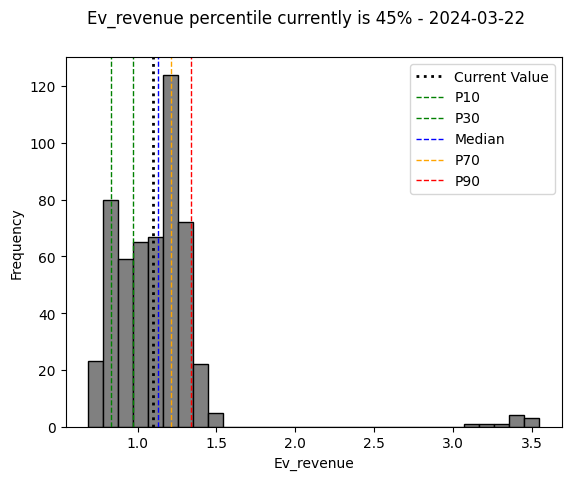

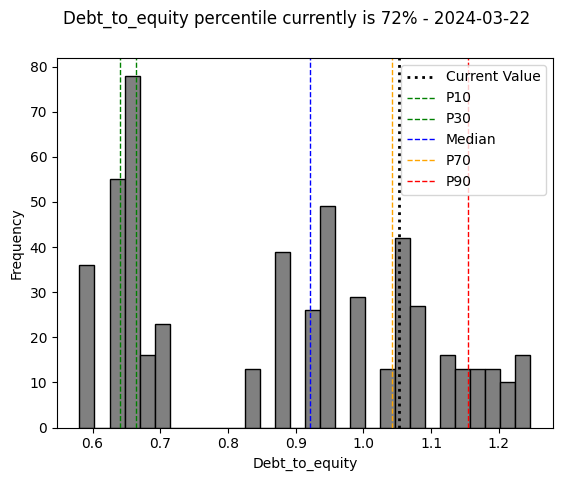

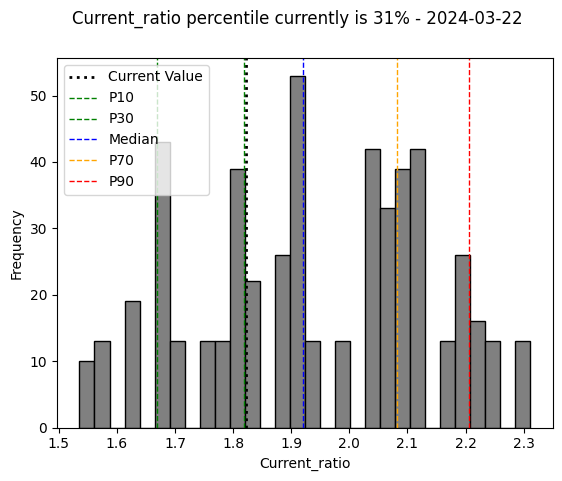

In [19]:
# plot histograms of value parameters
utils.plot_histogram_value_parameters(input_df=merged_nat_curr, extra_parameters=[], owned_shares=owned_shares)

## Calculate correlation between value parameters

In [20]:
# calulate value parameters Pearson's correlation coefficient
pd.DataFrame(merged_nat_curr, columns=['roa', 'roe', 'pe_ratio', 'pb_ratio', 'ps_ratio', 'ev_revenue', 'debt_to_equity', 'current_ratio']).corr()

,roa,roe,pe_ratio,pb_ratio,ps_ratio,ev_revenue,debt_to_equity,current_ratio
roa,1.000000,0.995675,0.165092,0.536250,0.399469,0.259942,0.028241,0.125005
roe,0.995675,1.000000,0.153781,0.560066,0.419503,0.293266,0.081063,0.102312
pe_ratio,0.165092,0.153781,1.000000,0.267935,0.244013,0.083976,-0.259349,0.115362
pb_ratio,0.536250,0.560066,0.267935,1.000000,0.533425,0.291665,0.336390,0.213171
ps_ratio,0.399469,0.419503,0.244013,0.533425,1.000000,0.918574,-0.088599,0.386556
ev_revenue,0.259942,0.293266,0.083976,0.291665,0.918574,1.000000,0.078530,0.317733
debt_to_equity,0.028241,0.081063,-0.259349,0.336390,-0.088599,0.078530,1.000000,-0.070243
current_ratio,0.125005,0.102312,0.115362,0.213171,0.386556,0.317733,-0.070243,1.000000


0 timestemos have been found!


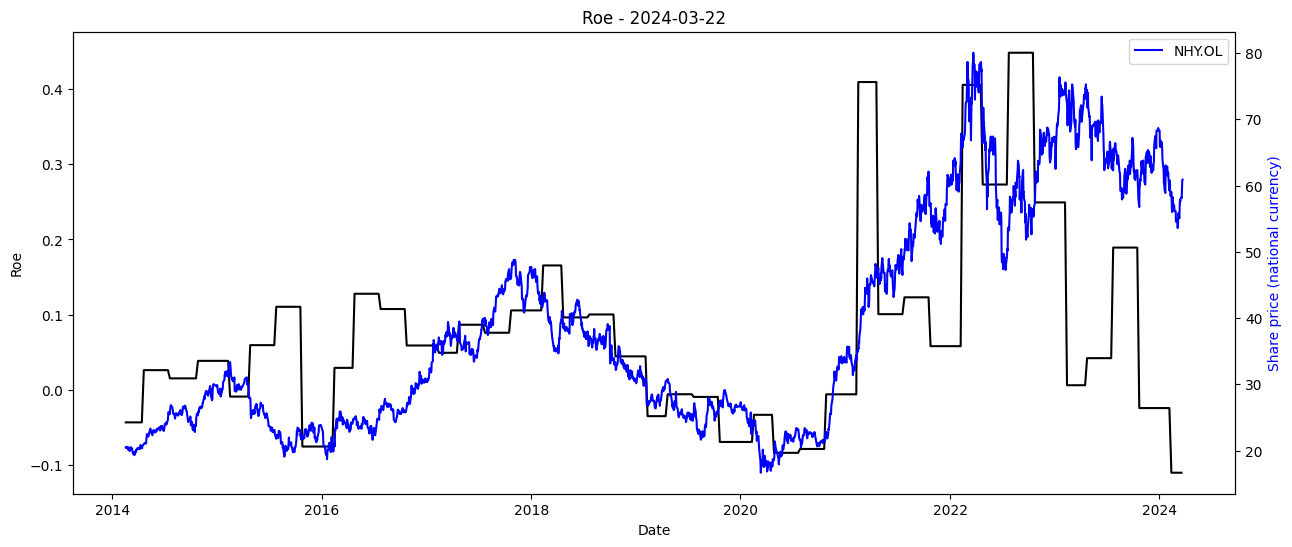

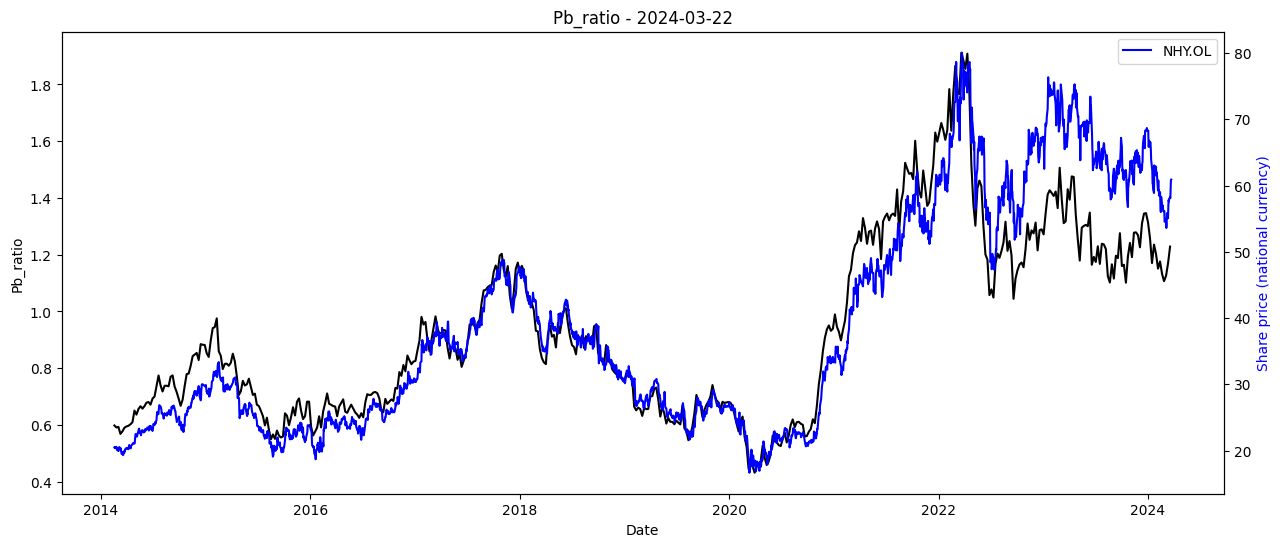

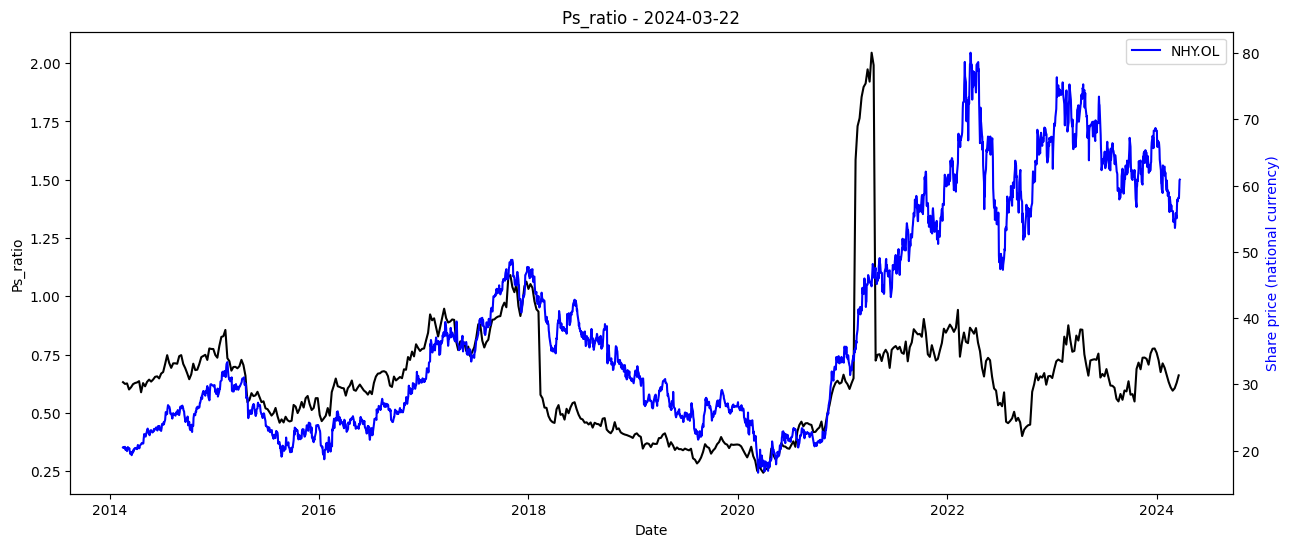

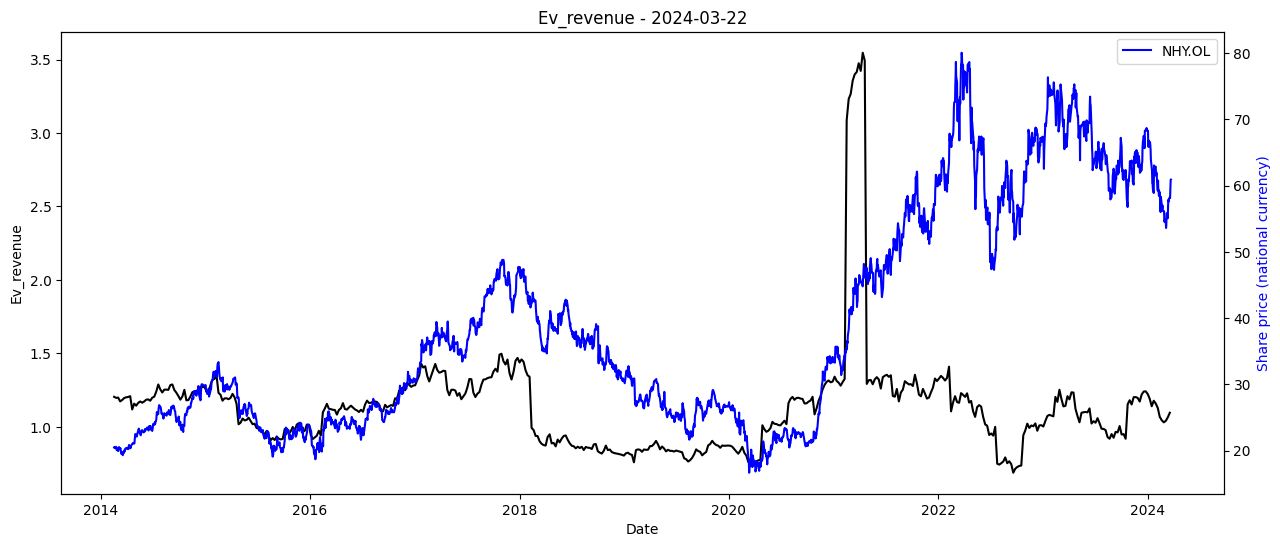

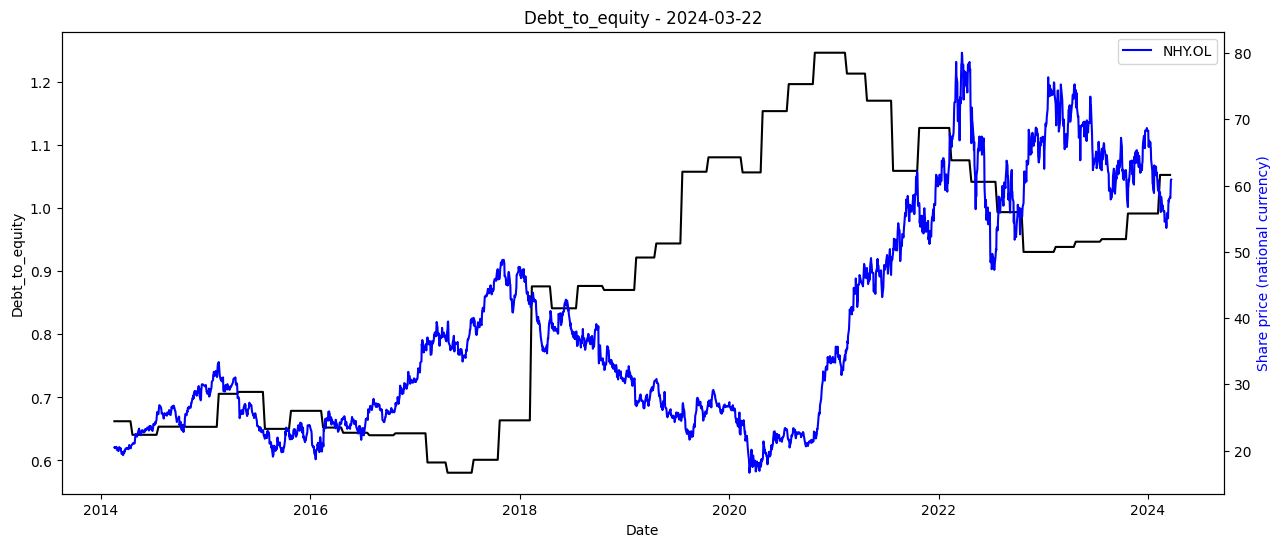

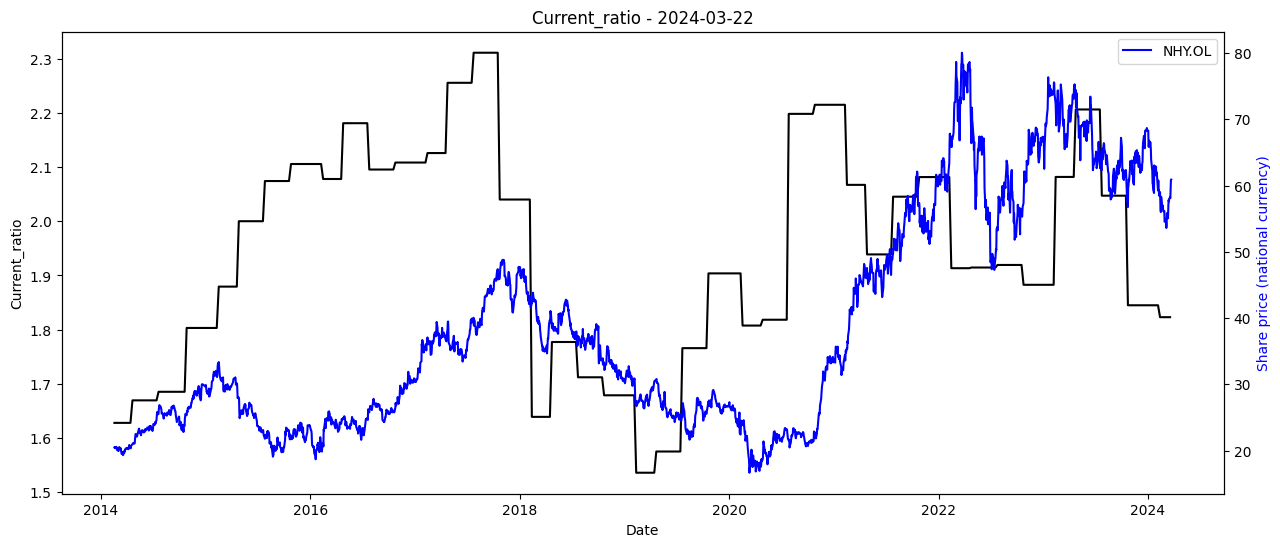

In [21]:
# plot value parameters in time and identify similar events
utils.get_historical_analouges(
    input_df=merged_nat_curr,
    ticker_all_price=ticker_all_price,
    share_name=share_name,
    tolerance=0.2,
    owned_shares=owned_shares
    )